# Diabetes Prediction using K-Nearest Neighbors (KNN) — From Scratch with NumPy

In this project, we build a **K-Nearest Neighbors (KNN)** classifier **from scratch using NumPy** to predict the likelihood of **diabetes** in patients based on medical attributes such as glucose level, BMI, and age.  

The goal is to **understand KNN at a deeper level**, by implementing it manually rather than relying on black-box libraries like `scikit-learn`, while also applying it to a **real-world healthcare dataset**.  

Through this project, we will:
- Explore and preprocess a diabetes dataset.
- Implement the KNN algorithm step by step in NumPy.
- Evaluate its performance on predicting diabetes outcomes.
- Compare results with scikit-learn’s KNN for validation.  

We are going to use the [Healthcare Diabetes Dataset form Kaggle](https://www.kaggle.com/datasets/nanditapore/healthcare-diabetes)


## 1. Import Libraries

In [1]:
# Import essential libraries
import math
import warnings
from collections import Counter

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import levene, ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Suppress unnecessary warnings for cleaner output
warnings.filterwarnings('ignore')

# Set visualization style for consistency and readability
sns.set(style='white')
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.alpha'] = 0.5

## 2. Import Dataset and Preview

In this section, we load the **Diabetes dataset** into our environment to understand its structure and features. We’ll perform a quick preview to inspect the first few records, check the dataset information, and identify key variables for our KNN model.

In [2]:
# Load dataset
data = pd.read_csv("Healthcare-Diabetes.csv")

# Preview a few rows
data.head()

,Id,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,6,148,72,35,0,33.6,0.627,50,1
1,2,1,85,66,29,0,26.6,0.351,31,0
2,3,8,183,64,0,0,23.3,0.672,32,1
3,4,1,89,66,23,94,28.1,0.167,21,0
4,5,0,137,40,35,168,43.1,2.288,33,1


- The dataset contains **medical and demographic features** related to diabetes diagnosis.  
- Each row represents a patient record with attributes such as **Glucose**, **BloodPressure**, **BMI**, and **Age**, among others.  
- The target variable, `Outcome`, indicates whether a patient is diabetic (`1`) or non-diabetic (`0`).  
- This dataset will be used to train and evaluate our KNN model for predicting diabetes likelihood.

In [3]:
# Dataset information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2768 entries, 0 to 2767
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Id                        2768 non-null   int64  
 1   Pregnancies               2768 non-null   int64  
 2   Glucose                   2768 non-null   int64  
 3   BloodPressure             2768 non-null   int64  
 4   SkinThickness             2768 non-null   int64  
 5   Insulin                   2768 non-null   int64  
 6   BMI                       2768 non-null   float64
 7   DiabetesPedigreeFunction  2768 non-null   float64
 8   Age                       2768 non-null   int64  
 9   Outcome                   2768 non-null   int64  
dtypes: float64(2), int64(8)
memory usage: 216.4 KB


- The dataset consists of **2,768 patient records** and **10 features**, including both numerical and categorical variables.  
- All columns contain **non-null values**, which means there are no missing entries to handle at this stage.  
- Most variables are integers, with a few continuous features (`BMI`, `DiabetesPedigreeFunction`) represented as floats.  
- This structure makes the dataset well-suited for applying the KNN algorithm.


## 3. Data Cleaning

Before training our model, it’s essential to clean and prepare the data to ensure reliability.  
In this step, we will:
- Check for duplicated records.
- Check for **missing or invalid values** (e.g., zeros in medical fields that cannot be zero).
- Drop unnecessary columns such as identifiers that do not contribute to prediction.


In [4]:
# Check duplicated records
print(f'Duplicated rows: {data.duplicated().sum()}')

Duplicated rows: 0


In [5]:
# Identify columns where zeros are biologically implausible (treated as missing)
cols_with_zero = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

data[cols_with_zero] = data[cols_with_zero].replace(0, np.nan)

print(f'Missing Values: {data.isnull().sum().sum()}')

Missing Values: 2312


In [6]:
# Fill missing values
data = data.fillna(data.median())

In [7]:
# Delete identifier column
data = data.drop(columns=['Id'])

## 3. Exploratory Data Analysis (EDA)

In this section, we explore the dataset to understand the **distribution, relationships, and patterns** within the features.  
EDA helps identify potential **outliers**, **imbalances**, and **correlations** that may influence the performance of the KNN model.

### 3.1 Distribution of the Target (`Outcome`).

- Our dataset seems clean since there are no missing values, data seems consistent and the datatypes also seem correct. The only thing we will do is check for duplicates and delete the identifier column.
- Let’s begin by examining the distribution of the target variable **`Outcome`**, which indicates whether a patient is diabetic (`1`) or non-diabetic (`0`).  
- Understanding this distribution helps us assess **class balance**, an important factor that can influence model performance.

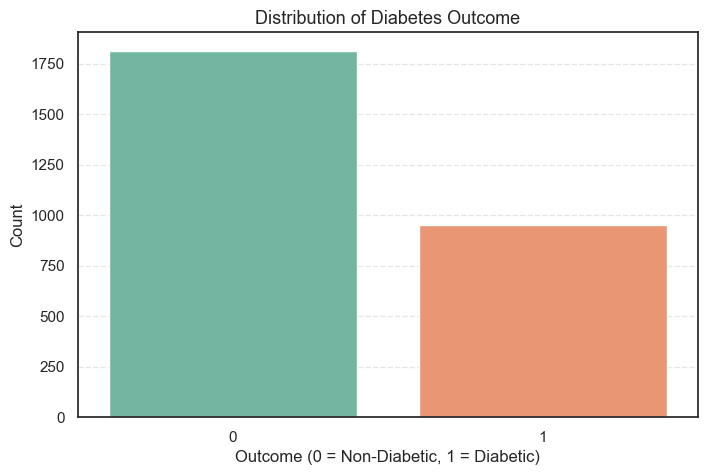

In [8]:
# Analyze the distribution of the target variable
sns.countplot(data=data, x='Outcome', palette='Set2')
plt.title('Distribution of Diabetes Outcome', fontsize=13)
plt.xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)')
plt.ylabel('Count')
plt.show()

In [9]:
# Display class balance in percentage
data['Outcome'].value_counts().to_frame(name='Count').assign(
    Percent=lambda x: round((x['Count'] / x['Count'].sum()) * 100, 2))

,Count,Percent
Outcome,,
0,1816,65.61
1,952,34.39


- The target distribution shows that **65.6%** of the patients are **non-diabetic (`0`)**, while **34.4%** are **diabetic (`1`)**.  
- This indicates a **moderate class imbalance**, which is common in medical datasets and should be considered when evaluating model performance.

### 3.2 Univariate Variable Analysis

- In this step, we examine each feature individually to understand its **distribution**, **spread**, and **presence of outliers**.  
- Analyzing variables one at a time helps identify skewed data and extreme values that could affect the KNN algorithm’s distance-based calculations.


In [10]:
cols = data.drop(columns=['Outcome']).columns

# Statistical information
data[cols].describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,2768.0,3.742775,3.323801,0.000,1.000,3.000,6.000,17.00
Glucose,2768.0,121.863439,30.503499,44.000,99.000,117.000,141.000,199.00
BloodPressure,2768.0,72.385838,11.988549,24.000,64.000,72.000,80.000,122.00
SkinThickness,2768.0,29.205925,9.032220,7.000,25.000,29.000,32.000,110.00
Insulin,2768.0,140.669798,82.887979,14.000,120.000,126.000,130.000,846.00
BMI,2768.0,32.593895,7.103462,18.200,27.575,32.400,36.625,80.60
DiabetesPedigreeFunction,2768.0,0.471193,0.325669,0.078,0.244,0.375,0.624,2.42
Age,2768.0,33.132225,11.777230,21.000,24.000,29.000,40.000,81.00


The dataset shows a wide range of values across medical features:

- **Glucose** levels range from 44 to 199, with a mean of ~122, indicating variability among patients’ blood sugar levels.  
- **BMI** averages around 32.6, suggesting that many patients fall in the overweight category, a known risk factor for diabetes.  
- **Insulin** values have a high standard deviation, showing significant spread and possible outliers.  
- **Age** distribution (mean ≈ 33 years) suggests a relatively young population in this dataset.  

Overall, the features show reasonable variation, which provides useful information for the KNN model to distinguish between diabetic and non-diabetic patients.

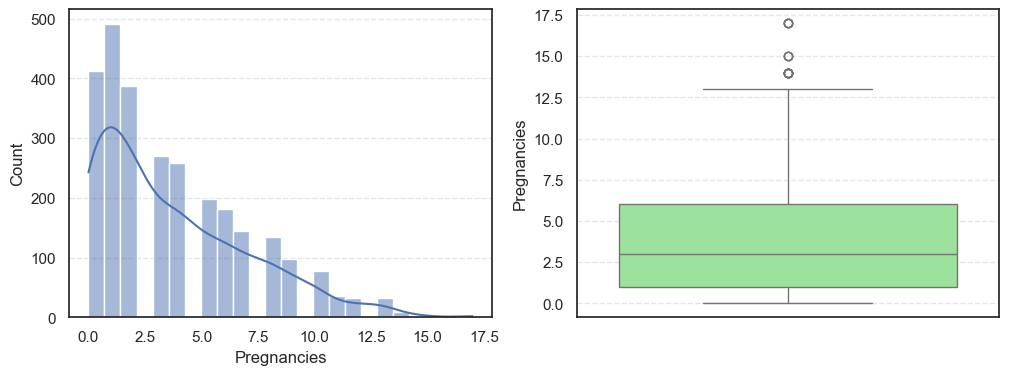

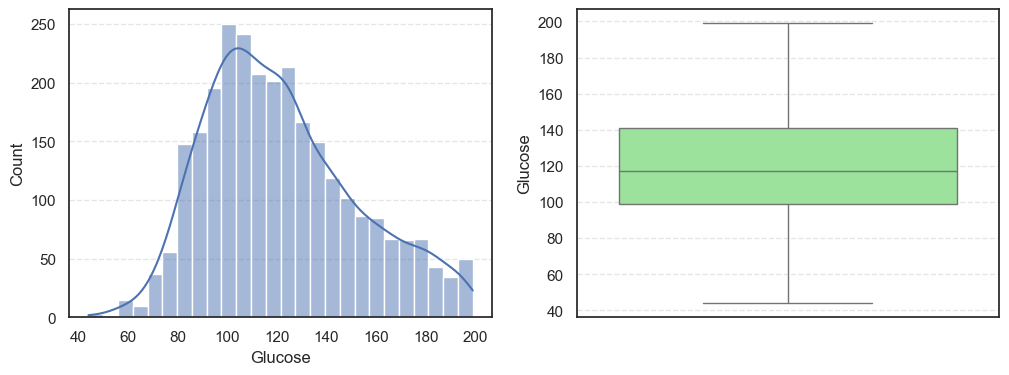

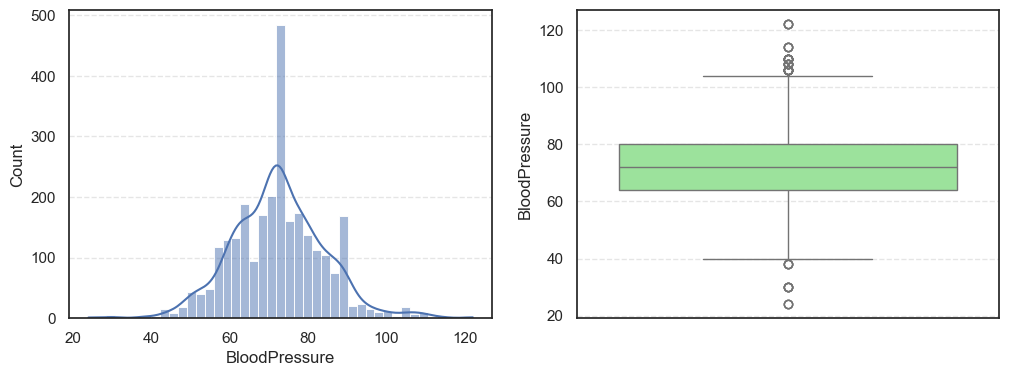

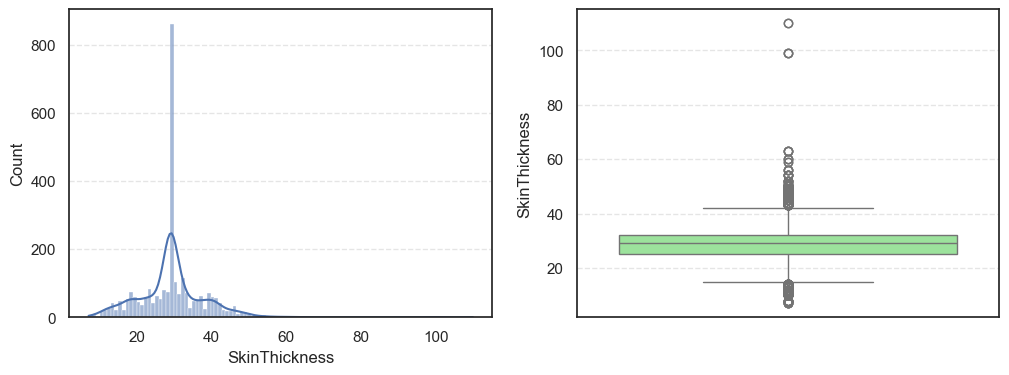

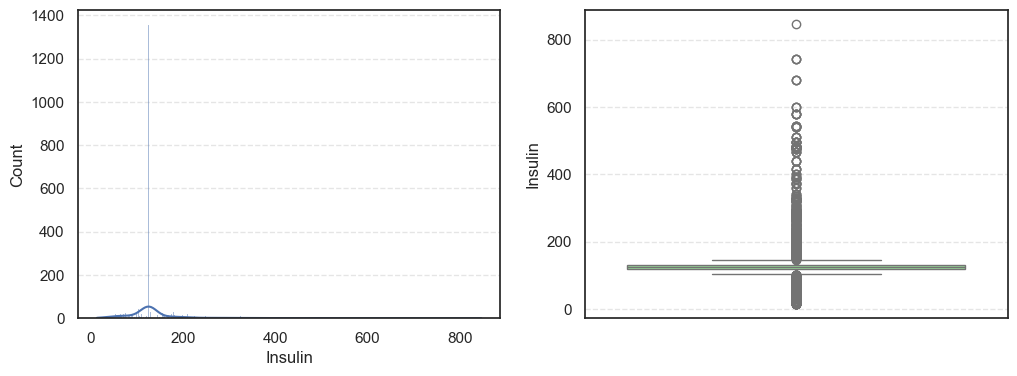

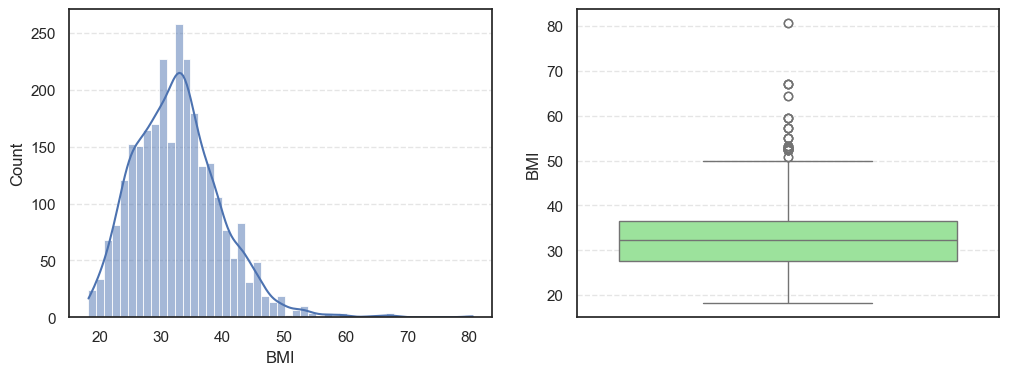

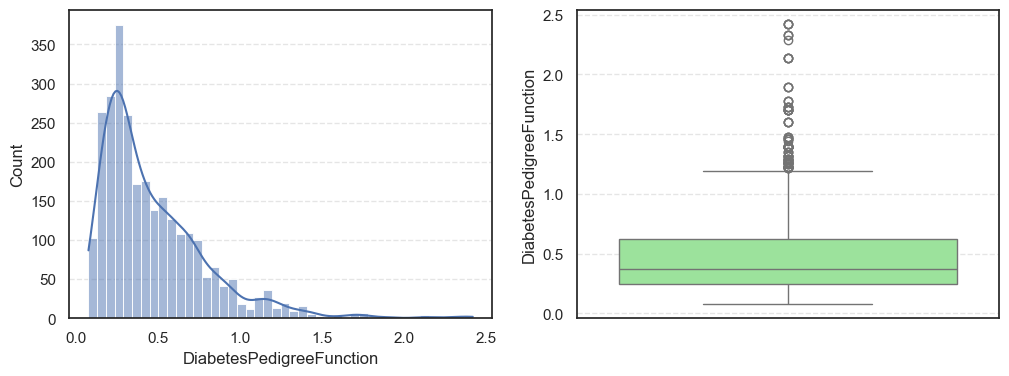

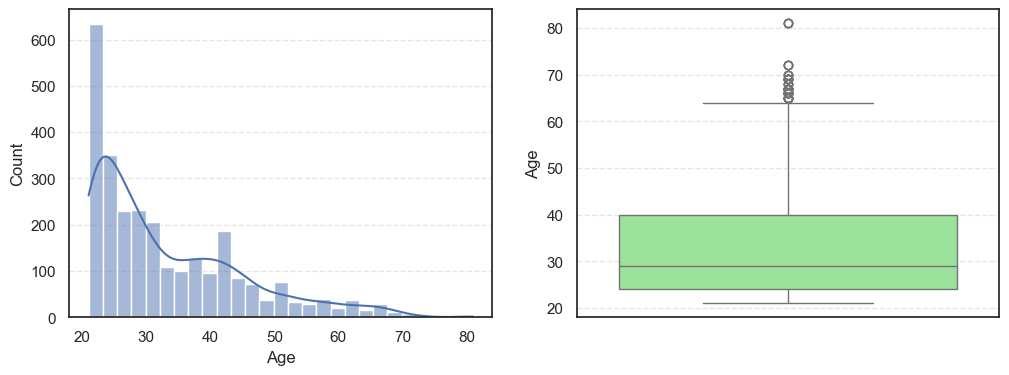

In [11]:
# Plot the distribution
for col in cols:
    plt.figure(figsize=(12, 4))

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data=data, x=col, kde=True)

    # Boxplot
    plt.subplot(1, 2, 2)
    sns.boxplot(data=data, y=col, color='lightgreen')

In [12]:
for col in cols:
    q1 = data[col].quantile(0.25)
    q3 = data[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - iqr * 1.5
    upper = q3 + iqr * 1.5
    outliers = data[(data[col] < lower) | (data[col] > upper)][col]
    print(f'=== {col} ===')
    print(f'Outliers: {len(outliers)}')
    print(f'Skew: {data[col].skew()}', '\n')

=== Pregnancies ===
Outliers: 16
Skew: 0.9590963213692726 

=== Glucose ===
Outliers: 0
Skew: 0.5211305020647523 

=== BloodPressure ===
Outliers: 49
Skew: 0.1974036294152549 

=== SkinThickness ===
Outliers: 316
Skew: 1.191207865894857 

=== Insulin ===
Outliers: 1126
Skew: 3.1015773566846057 

=== BMI ===
Outliers: 38
Skew: 0.8534493332926469 

=== DiabetesPedigreeFunction ===
Outliers: 97
Skew: 1.8427906939007215 

=== Age ===
Outliers: 64
Skew: 1.1662989470696625 



The distribution analysis reveals the following patterns across the features:

- `Pregnancies`: Slightly right-skewed **(≈0.96)**, meaning most patients have few pregnancies, but a few have many. Only a small number of outliers **(16)** are present.  
- `Glucose`: Nearly symmetric with minimal skew **(≈0.52)** and no significant outliers — a stable feature for modeling.  
- `BloodPressure`: Slight right skew and moderate spread with 49 outliers, indicating a few unusually high or low blood pressure readings.  
- `SkinThickness`: Noticeably right-skewed **(≈1.19)** with many outliers **(316)**, showing variation in body fat levels across patients.  
- `Insulin`: Highly right-skewed **(≈3.10)** and heavily affected by outliers **(1,126)**, suggesting extreme insulin values that may distort model performance without scaling.  
- `BMI`: Moderately right-skewed **(≈0.85)** with a few outliers, but overall distribution appears reasonable.  
- `DiabetesPedigreeFunction`: Strong right skew **(≈1.84)**, indicating that most patients have low genetic risk, with a few very high-risk cases.  
- `Age`: Positively skewed **(≈1.17)**, showing that most patients are young adults, with fewer older individuals.

Overall, the data shows **non-normal distributions and several outliers**, particularly in `Insulin` and `SkinThickness`.  

This confirms the need for **feature scaling** before applying KNN, as distance-based models are sensitive to differences in scale and extreme values.

### 3.3 Feature Relationship with Target (Outcome)

- Next, we explore how each feature relates to the target variable **`Outcome`**.  
- This helps us identify which medical indicators, such as glucose level, BMI, or age, show clear differences between diabetic and non-diabetic patients.  
- Understanding these relationships provides valuable insights before building the predictive KNN model.

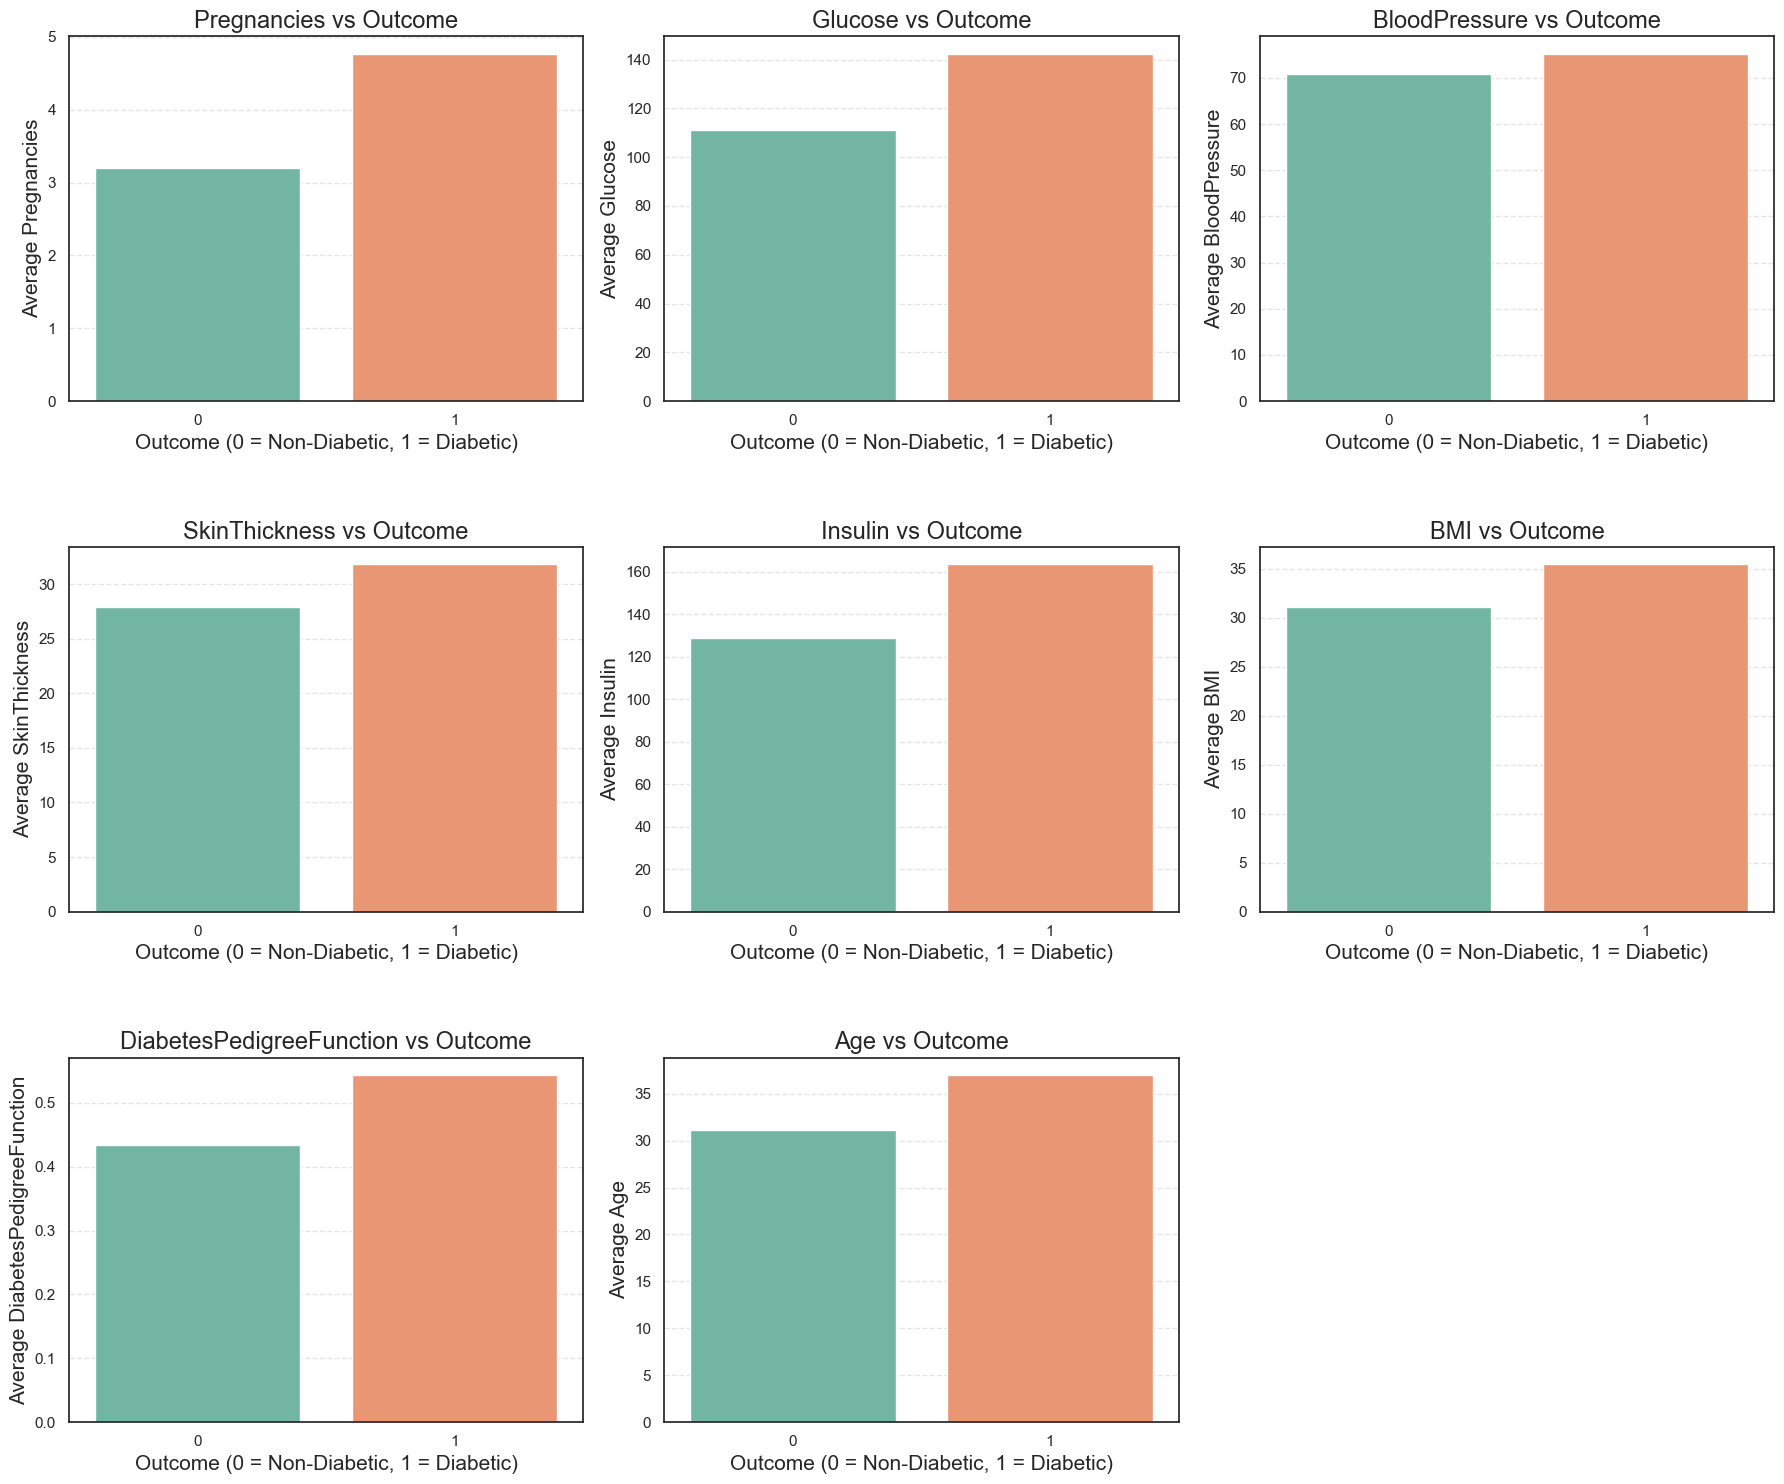

In [13]:
# Plot mean feature Comparison with the target (Outcome)

n_cols = 3
n_rows = math.ceil(len(cols) / n_cols)

plt.figure(figsize=(6 * n_cols, 5 * n_rows))
for i, col in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.barplot(data=data, y=col, x='Outcome', ci=False, palette='Set2', estimator='mean')
    plt.title(f'{col} vs Outcome', fontsize=17)
    plt.xlabel('Outcome (0 = Non-Diabetic, 1 = Diabetic)', fontsize=15)
    plt.ylabel(f'Average {col}', fontsize=15)

plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()

- The grid of bar plots shows the **average value of each medical feature** for diabetic and non-diabetic patients.  
- Clear differences can be observed in variables like **Glucose**, **BMI**, and **Age**, which tend to have higher mean values among diabetic individuals.  
- This highlights these features as potentially strong predictors for the KNN model.

In [14]:
# Mean feature comparison by target (Outcome)
for col in cols:
    average = data.groupby('Outcome')[col].mean().to_frame(name='Mean')
    print(f'=== {col} ===')
    print(round(average, 2), '\n')

=== Pregnancies ===
         Mean
Outcome      
0        3.20
1        4.77 

=== Glucose ===
           Mean
Outcome        
0        111.06
1        142.46 

=== BloodPressure ===
          Mean
Outcome       
0        70.89
1        75.23 

=== SkinThickness ===
          Mean
Outcome       
0        27.85
1        31.79 

=== Insulin ===
           Mean
Outcome        
0        128.70
1        163.49 

=== BMI ===
          Mean
Outcome       
0        31.10
1        35.44 

=== DiabetesPedigreeFunction ===
         Mean
Outcome      
0        0.43
1        0.54 

=== Age ===
          Mean
Outcome       
0        31.11
1        36.99 



The average values show clear distinctions between diabetic and non-diabetic patients:

- **Glucose** and **BMI** show the largest differences, with diabetic patients having notably higher averages — consistent with medical expectations.  
- **Insulin**, **SkinThickness**, and **Age** are also higher among diabetic individuals, suggesting their contribution to diabetes risk.  
- **BloodPressure** and **DiabetesPedigreeFunction** show moderate differences, while **Pregnancies** are slightly higher in the diabetic group.

Overall, these trends highlight **Glucose**, **BMI**, and **Age** as key predictive features for the KNN model.

In [15]:
# T-test
alpha = 0.05
for col in cols:
    diabetes = data[data['Outcome'] == 1][col]
    no_diabetes = data[data['Outcome'] == 0][col]
    _, lev_p = levene(diabetes, no_diabetes, center='median')
    equal_var = lev_p >= alpha
    t_stat, p_value = ttest_ind(diabetes, no_diabetes, equal_var=equal_var)
    print(f'=== {col} ===')
    print(f't-stat: {t_stat:.4f}, p-value: {p_value:.4f}')
    print(f'Test: {"Standard" if equal_var else "Welch"}')
    print(f'Null Hypothesis (Ho): Average {col} are similar whether with diabetes or not.')
    decision = "Reject null hypothesis they are the same." if p_value < alpha else "Fail to reject null hypothesis they are the same"
    print(f'Decision: {decision}', '\n')

=== Pregnancies ===
t-stat: 11.2158, p-value: 0.0000
Test: Welch
Null Hypothesis (Ho): Average Pregnancies are similar whether with diabetes or not.
Decision: Reject null hypothesis they are the same. 

=== Glucose ===
t-stat: 28.1009, p-value: 0.0000
Test: Welch
Null Hypothesis (Ho): Average Glucose are similar whether with diabetes or not.
Decision: Reject null hypothesis they are the same. 

=== BloodPressure ===
t-stat: 9.1720, p-value: 0.0000
Test: Standard
Null Hypothesis (Ho): Average BloodPressure are similar whether with diabetes or not.
Decision: Reject null hypothesis they are the same. 

=== SkinThickness ===
t-stat: 11.2422, p-value: 0.0000
Test: Welch
Null Hypothesis (Ho): Average SkinThickness are similar whether with diabetes or not.
Decision: Reject null hypothesis they are the same. 

=== Insulin ===
t-stat: 9.9030, p-value: 0.0000
Test: Welch
Null Hypothesis (Ho): Average Insulin are similar whether with diabetes or not.
Decision: Reject null hypothesis they are the 

- A two-sample t-test was conducted to compare the mean values of each feature between diabetic and non-diabetic groups.  
- All features returned **p-values < 0.05**, indicating statistically significant differences in their averages across the two groups.  
- This means that attributes such as **Glucose**, **BMI**, **Age**, and **Insulin** differ meaningfully between diabetic and non-diabetic patients, reinforcing their importance as predictors for our KNN model.

## 4. Implementing K Nearest Neighbor (KNN) with Numpy


In this section, we will **build the KNN algorithm from scratch using NumPy** to gain a clear understanding of how it works internally. 
 
Instead of relying on pre-built libraries, we’ll manually implement each step, from calculating distances to predicting classes based on the majority vote of the nearest neighbors.  

This hands-on approach will strengthen our understanding of **distance-based learning** and the intuition behind how KNN makes predictions.

### 4.1 Building the KNN Classifier from Scratch

We start by defining a helper function to compute **Euclidean distance** and then build the **KNN class**. 
 
This class will handle data storage (`fit`), distance calculation, and prediction through **majority voting** among the nearest neighbors.

In [16]:
# Helper function
def euclidean_distance(x1, x2):
    """
    Calculate the Euclidean distance between two points.
    :param x1: (1D numeric array) First point
    :param x2: (1D numeric array) Second point
    :return: (Float) Euclidean distance between x1 and x2.
    """
    return np.sqrt(np.sum((x1 - x2) ** 2))

In [17]:
# KNN Class
class KNN:
    def __init__(self, k=3):
        """
        Initializes the KNN model.
        :param k: (int) Number of nearest neighbors to consider.
        """
        self.k = k
        self.X_train = None
        self.y_train = None
    
    def fit(self, X_train, y_train):
        """
        
        :param X_train: Training feature matrix.
        :param y_train: Training labels.
        :return: None
        """
        self.X_train = np.array(X_train, dtype=float)
        self.y_train = np.array(y_train)
    
    def _predict_single(self, x):
        """
        Predict the label for a single sample using majority vote among k nearest neighbors.
        :param x: Single sample to classify.
        :return: Predicted label for the input sample.
        """
        # Ensure input is numeric
        x = np.array(x, dtype=float)
    
        # 1. Compute distances between x and all training samples
        distances = [euclidean_distance(x, x_train) for x_train in self.X_train]
    
        # 2. Identify indices of the k nearest neighbors
        k_indices = np.argsort(distances)[:self.k]
    
        # 3. Retrieve neighbor labels and perform majority voting
        k_neighbour_labels = [self.y_train[i] for i in k_indices]
        most_common = Counter(k_neighbour_labels).most_common(1)

        return most_common[0][0]

    def predict(self, X_test):
        """
        Predict labels for all samples in X_test.
        :param X_test: Test feature matrix.
        :return: Predicted labels for the test set.
        """
        X_test = np.array(X_test, dtype=float)
        predictions = [self._predict_single(x) for x in X_test]
        return np.array(predictions)

### 4.2 Applying the KNN Model

In this step, we’ll use our custom **KNN implementation** to make predictions on the prepared dataset. 
 
We’ll fit the model with the training data and then predict outcomes for the test set to evaluate how well it can classify patients as diabetic or non-diabetic based on their medical features.

In [18]:
# Separate features from labels
X = data.drop(columns=['Outcome'])
y = data['Outcome']

# Split train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize features
X_train_scaled = (X_train - X_train.mean(axis=0)) / X_train.std(axis=0)
X_test_scaled = (X_test - X_train.mean(axis=0)) / X_train.std(axis=0)

# Initialize and fit the KNN model
knn = KNN(k=5)
knn.fit(X_train_scaled.values, y_train.values)

# Predict on test data
y_pred = knn.predict(X_test_scaled)
y_pred[:10]

array([0, 0, 1, 0, 1, 0, 0, 0, 1, 1])

### 4.3 Model Evaluation
We assess model performance using accuracy, confusion matrix, and classification metrics (precision, recall, F1-score) to understand how well KNN predicts diabetes outcomes.

In [19]:
print(f'Accuracy: {round(accuracy_score(y_test, y_pred), 4)}', '\n')
print(f'Confusion Matrix:\n{confusion_matrix(y_test, y_pred)}', '\n')
print(classification_report(y_test, y_pred))

Accuracy: 0.8351 

Confusion Matrix:
[[484  78]
 [ 59 210]] 

              precision    recall  f1-score   support

           0       0.89      0.86      0.88       562
           1       0.73      0.78      0.75       269

    accuracy                           0.84       831
   macro avg       0.81      0.82      0.82       831
weighted avg       0.84      0.84      0.84       831



#### Model Evaluation Results

The custom KNN model achieved an **accuracy of 83.5%**, indicating strong predictive performance on the diabetes dataset.

- The **confusion matrix** shows:
  - 484 true negatives (correctly predicted non-diabetic)
  - 210 true positives (correctly predicted diabetic)
  - 78 false positives and 59 false negatives.

- The **precision (0.89 for class 0, 0.73 for class 1)** and **recall (0.86 for class 0, 0.78 for class 1)** demonstrate that the model performs consistently across both classes, though slightly better for non-diabetic predictions.

Overall, these results suggest that the KNN model effectively distinguishes between diabetic and non-diabetic patients, making it a strong baseline classifier built purely with NumPy.


## Conclusion

In this project, we implemented the **K-Nearest Neighbors (KNN)** algorithm entirely from scratch using **NumPy** and applied it to a real-world **diabetes prediction** dataset. 
 
Through careful data preprocessing, scaling, and evaluation, the model achieved an accuracy of **83.5%**, demonstrating that even a simple, manually built KNN can perform effectively on healthcare data.  

This hands-on approach provided valuable insight into how KNN works under the hood, from distance calculation to majority voting, forming a strong foundation for understanding and comparing more advanced machine learning algorithms.